In [2]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit
import lmfit as lm

import matplotlib.pyplot as plt
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
import sys, importlib

import sys
sys.path.append('./XPCSlibrary/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorrelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

### EXPERIMENTAL VARIABLES ###
XPCS.set_expvar(Nx//2, Ny//2, 5)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

from folder_paths import *

ponifile = "../PROCESSED_DATA/LAB6_calib_scan4.poni"


## Load masks

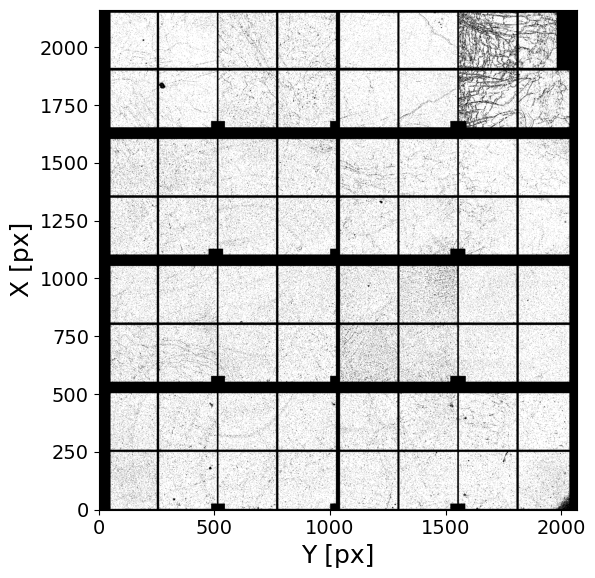

In [3]:
e4m_mask = np.load(MASKS_folder+'e4m_mask'+'.npy')
e4m_htmask = np.load(MASKS_folder+'e4m_htmask_Mo_fluorescence'+'.npy')

plt.figure(figsize=(6, 6))
plt.imshow((e4m_mask*e4m_htmask).reshape(Nx,Ny), cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

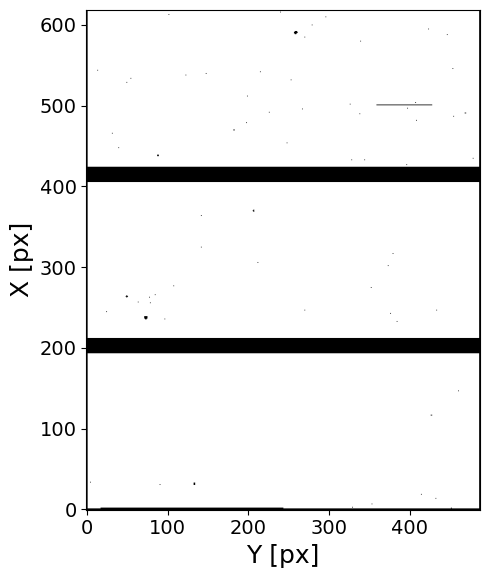

In [4]:
pilatus_mask = ~np.load(MASKS_folder+'pilatus300k_mask_20240201'+'.npy')

plt.figure(figsize=(6, 6))
plt.imshow(pilatus_mask, cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

## Q mask

In [5]:
#######################################
sample_name = 'Ta2O5_2.5um'
Ndataset = 2
Nscan = 3
Nfi, Nff = 0, 80_000
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#############################
command = mtimescan 0.001 2 86000501
Ei = 21.669991317784486
itime = 0.0011
theta = 10.0
Qc = 1.91
#############################



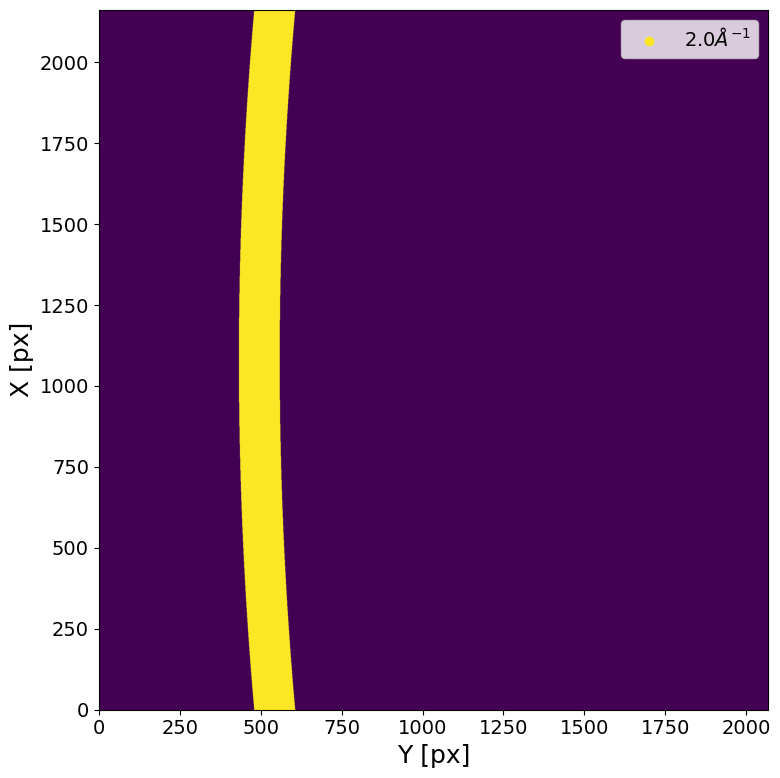

In [6]:
###########
Q = 2
dq = 0.01
###########
Q=float(Q)

#Qmask = XPCS.gen_Qmask(Ei, theta, Qc+np.array([-1,0,1])*2*dq, dq, Qmap_plot=False)
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)

## XPCS scan: delcoup=10, T=12h (Ta2O5_2.5um, 2, 4)

In [6]:
#######################################
sample_name = 'Ta2O5_2.5um'
Ndataset = 2
Nscan = 4
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_0002_0004.npy')
load_mask = e4m_mask*e4m_htmask*Qmask*Kossel_mask
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=None, Nff=None, load_mask=load_mask, n_jobs=50, )

#############################
command = mtimescan 0.001 2 86000501
Ei = 21.669991317784486
itime = 0.0011
T =  15.707186611111112 h
theta = 10.0
Qc = 1.91
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/10282 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/10282 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/10282 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/10282 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/10282 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/10282 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/10282 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/10282 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00053.h5 (54/10282 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/10282 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00054.h5 (55/10282 loops)
	 -> loading file eiger4m

### Intensity analysis
Beam crashed two times!

In [7]:
########################
Nf_down1 = 15492456
Nf_up1 = 16790601
Nf_down2 = 21877393
Nf_up2 = 23830327
########################

In [8]:
####################
Lbin = 1
Nstep = 100
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)

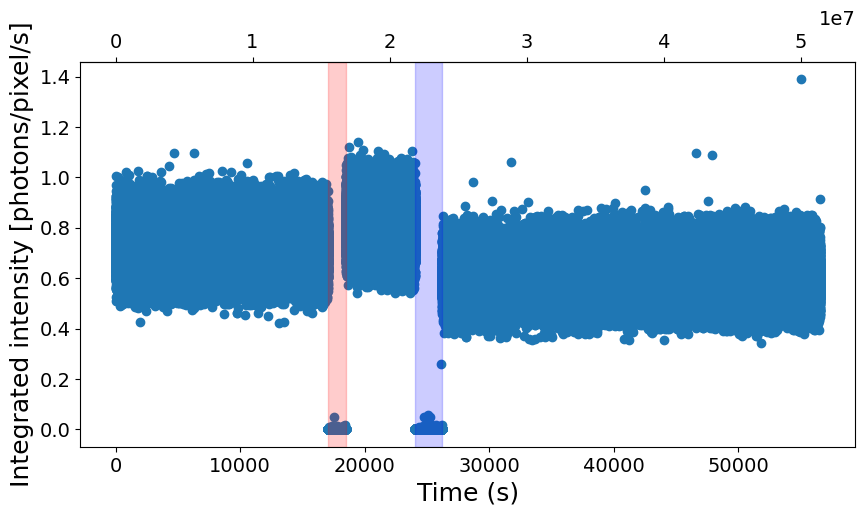

In [9]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.axvspan(t_It[Nf_down1//Nstep], t_It[Nf_up1//Nstep], color='red', alpha=0.2)
plt.axvspan(t_It[Nf_down2//Nstep], t_It[Nf_up2//Nstep], color='blue', alpha=0.2)
plt.show()

Cut the no-beam frams!

In [10]:
frame_mask = np.ones(e4m_data.shape[0], dtype=bool)
frame_mask[Nf_down1:Nf_up1] = False
frame_mask[Nf_down2:Nf_up2] = False
e4m_data = e4m_data[frame_mask, :]

Nf_downA = Nf_down1
Nf_downB = Nf_down2 - (Nf_up1 - Nf_down1)

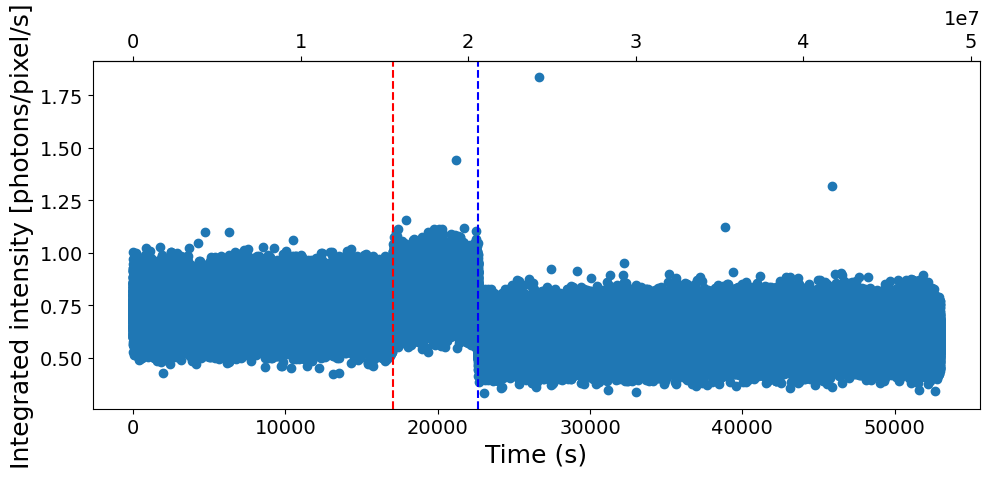

In [11]:
####################
Lbin = 1
Nstep = 100
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.axvline(t_It[Nf_downA//Nstep], color='red', linestyle='--', label='Nf_downA')
plt.axvline(t_It[Nf_downB//Nstep], color='blue', linestyle='--', label='Nf_downB')
plt.tight_layout(); plt.show()

### Flux check

################################################################################
Maximum count in the hull run -> 5.0
# of pixels above Ith_high treshold ->  4268374 pixels (of 4471016 => 95.47 %)
################################################################################



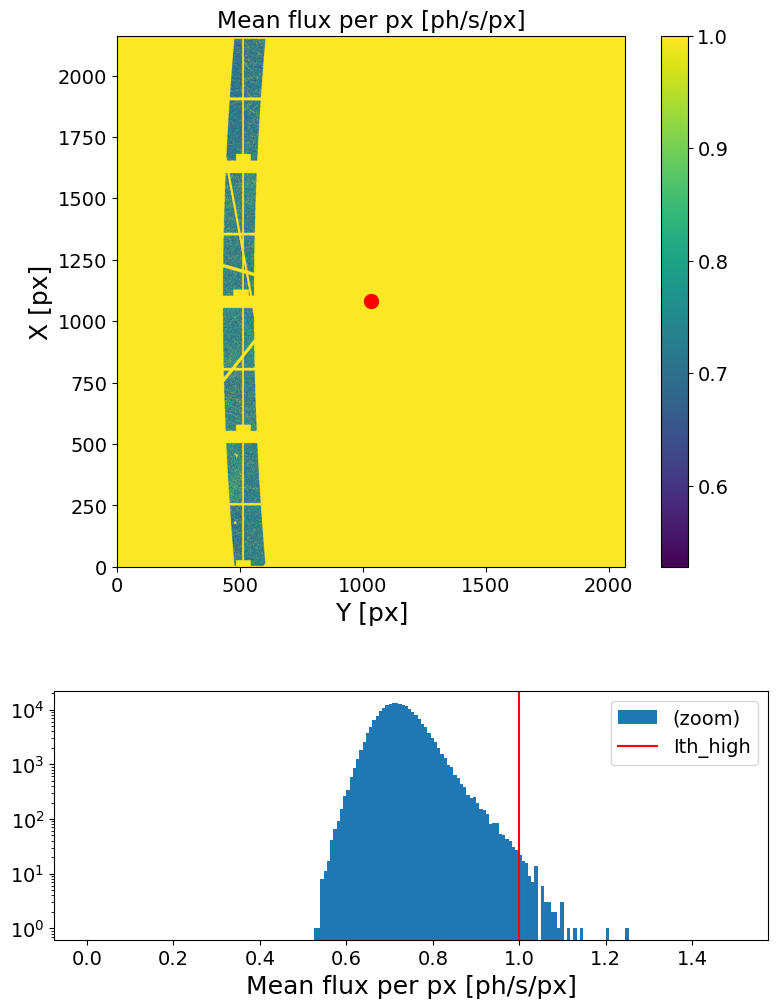

In [12]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=1, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Pilatus

In [13]:
'''
#######################################
sample_name = 'Ta2O5_2.5um'
Ndataset = 2
Nscan = 4
Nfi, Nff =  0, 100
#######################################
scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
for k in scan.keys(): print(f"{k} -> {scan[k]} ;")

pilatus_data = ID10.load_pilatus(RAW_folder, sample_name, Ndataset, Nscan, Nfi=0, Nff=300, Nstep=1)


plt.figure(figsize=(10, 6))
plt.imshow(pilatus_data[16], vmin=1400, vmax=4000)

q, Sq, dSq = XPCS.get_Sq(pilatus_data, ponifile=ponifile, mask=pilatus_mask)

XPCS.plot_Sq(q, Sq, itime=2, )
''';

### Linear correlation 4 tests

In [14]:
###################
Nfi = None#int(0e7)
Nff = None#int(None)
Lbin = 1000
bin2dense = True
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 0.0 s)
Binning frames (Lbin = 1000, using MKL library) ...


Done! (elapsed time = 61.43 s)
	 | 48154 frames X 202742 pixels
	 | memory usage (np.array @ float32) = 36.369 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 85.97 s)
	 | 48154 X 48154 squared matrix
	 | memory usage (np.array @ float32) = 8.638 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 2.76 s)



In [15]:
############################
t1, t2 = 0, 100
vmin, vmax = 1.0, 1.03
############################
#XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=None)

In [21]:
################
Nbunch = 20
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t, g2, t_mt, g2_mt = {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=True)
    else:         t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t), cython=True)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch])    


Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing 

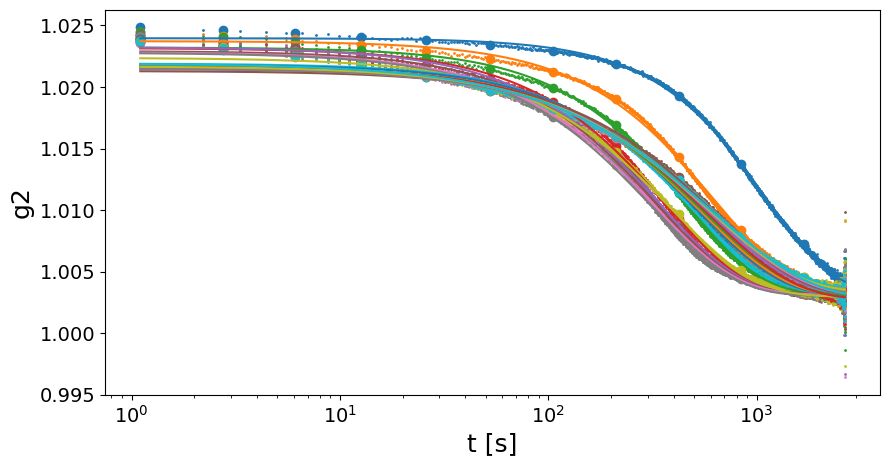

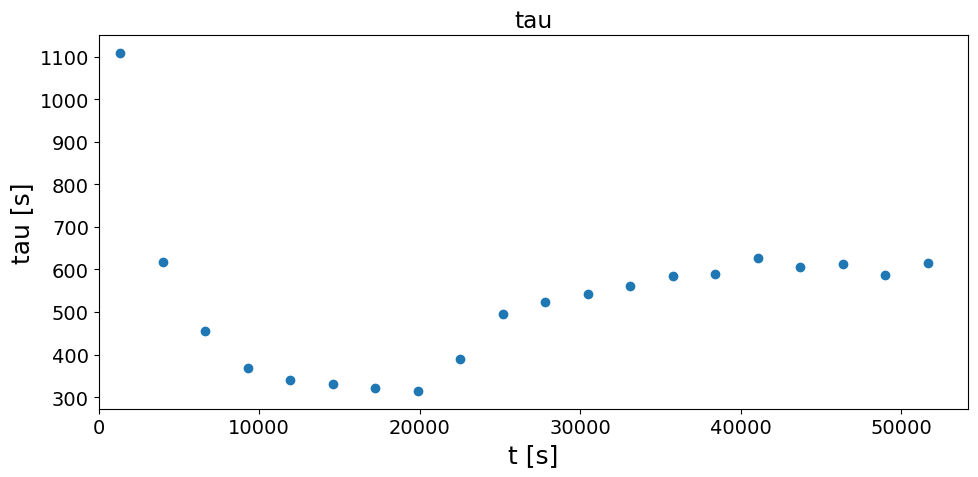

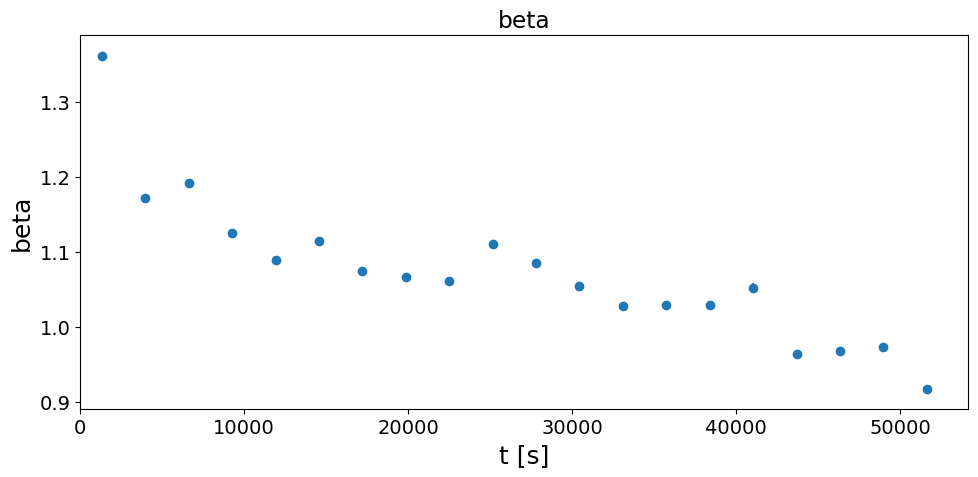

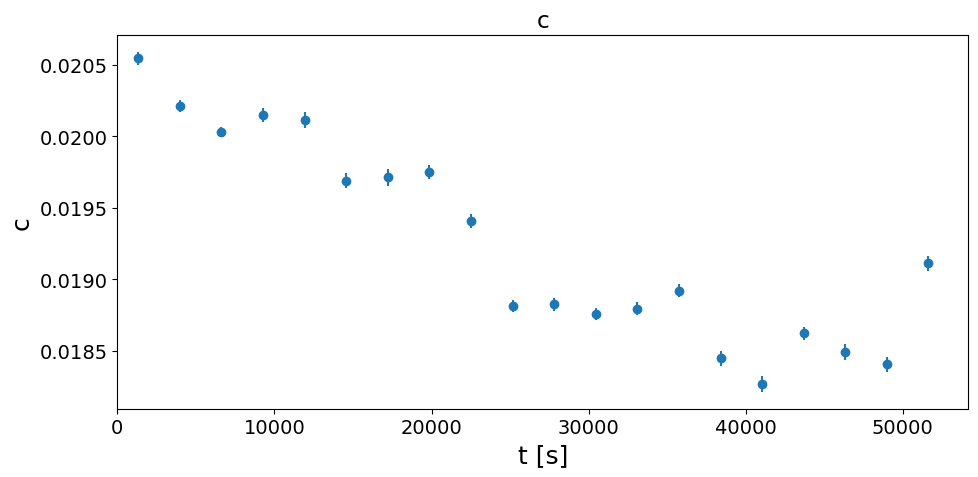

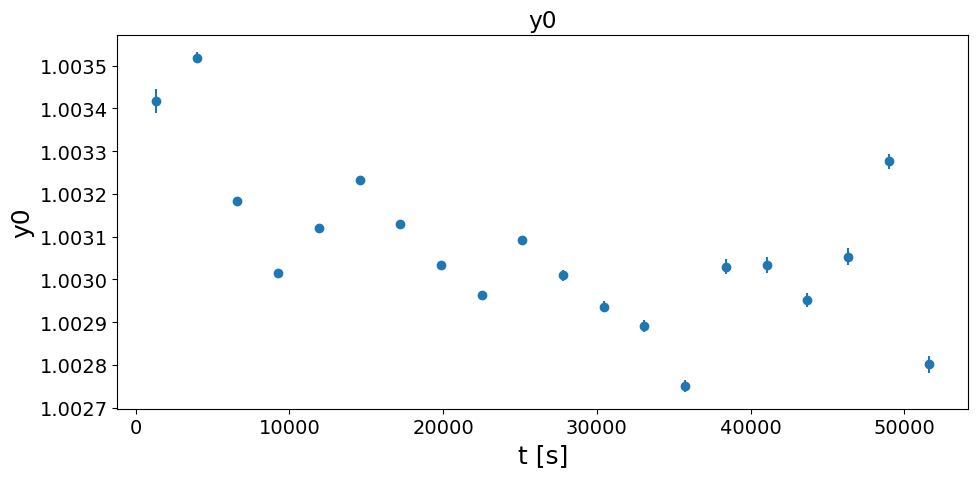

In [23]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], c='C'+str(i), label=str(k)+'s')

    x = t[k] [(t1_fit<t[k])*(t[k]<t2_fit)]
    y = g2[k][(t1_fit<t[k])*(t[k]<t2_fit)]
    fit = model.fit(y, params, t=x)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
#plt.ylim(1, 1.03)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [178]:
t_downA = Nf_down1*itime
t_downB = Nf_down2*itime
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nf_downA =', Nf_downA, ' =>  t_down1 =', t_downA)
print('Nf_downB =', Nf_downB, ' =>  t_down2 =', t_downB)
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nf_downA = 15492456  =>  t_down1 = 17041.7016
Nf_downB = 20579248  =>  t_down2 = 24065.1323
Nff =    = 48154460  =>  t_ff = 52969.906
#############################



In [186]:
t_segments = [
    (0, 2e3),
    (2e3, 4e3),
    (4e3, 6e3),
    (6e3, 8e3),
    (8e3, 10e3),
    (10e3, 12e3),
    (12e3, 14e3),
    (14e3, 16e3),
    (16e3, t_downA),
    (t_downA, 20e3),
    (20e3, 22e3),
    (22e3, t_downB),
    (t_downB, 26e3),
    (26e3, 28e3),
    (28e3, 30e3),
    (30e3, 32e3),
    (32e3, 34e3),
    (34e3, 36e3),
    (36e3, 38e3),
    (38e3, 40e3),
    (40e3, 42e3),
    (42e3, 44e3),
    (44e3, 46e3),
    (46e3, 48e3),
    (48e3, 50e3),
    (50e3, t_ff),
]

Nf_segments =  [(int(t_segments[i][0]//itime), int(t_segments[i][1]//itime)) for i in range(len(t_segments))]

In [187]:
###################
Lbin = 1000
bin2dense = True
mask = None
###################

t_g2, g2= {}, {}
for i in range(len(Nf_segments)):
    Nfi = Nf_segments[i][0]
    Nff = Nf_segments[i][1]
    G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

    t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
    t_g2[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t), cython=True)
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2)
# np.load(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.npz', allow_pickle=True)

Loading frames ...
Done! (elapsed time = 0.7 s)
Binning frames (Lbin = 1000, using MKL library) ...
Done! (elapsed time = 0.84 s)
	 | 1818 frames X 210139 pixels
	 | memory usage (np.array @ float32) = 1.423 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 0.26 s)
	 | 1818 X 1818 squared matrix
	 | memory usage (np.array @ float32) = 0.012 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.07 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Loading frames ...
Done! (elapsed time = 0.69 s)
Binning frames (Lbin = 1000, using MKL library) ...
Done! (elapsed time = 0.83 s)
	 | 1818 frames X 210139 pixels
	 | memory usage (np.array @ float32) = 1.423 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 0.3 s)
	 | 1818 X 1818 squared matrix
	 | memory usage (np.array @ float32) = 0.012 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.07 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Load

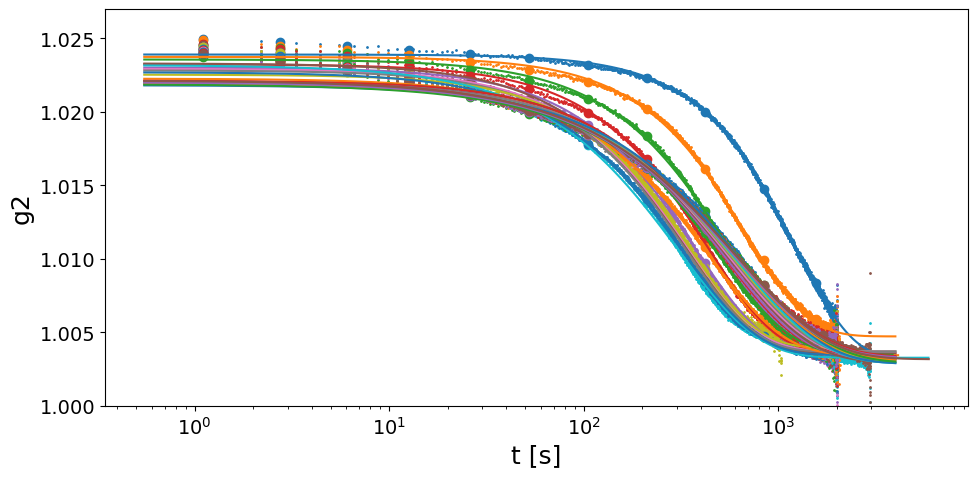

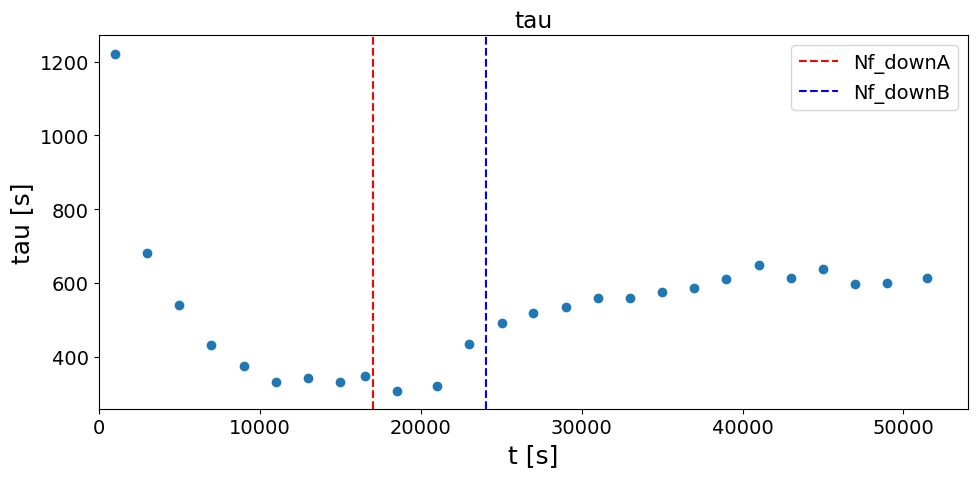

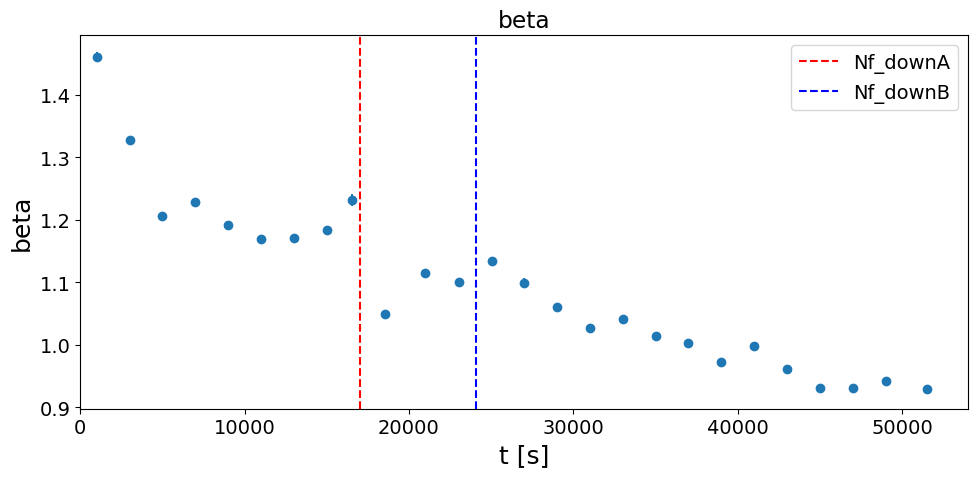

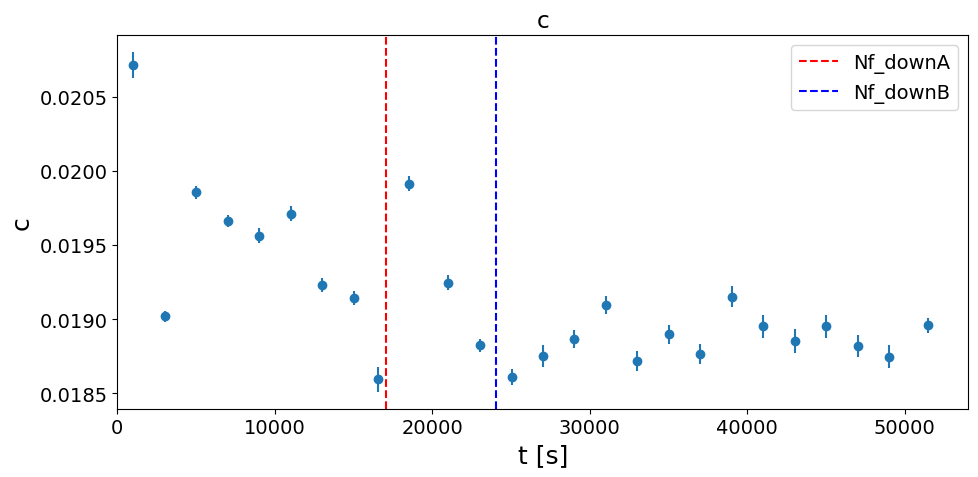

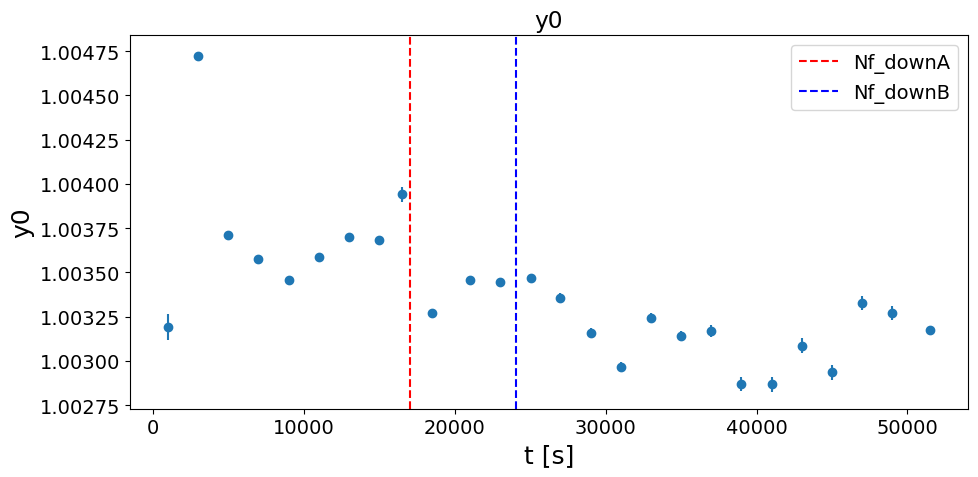

In [188]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k])
    plt.scatter(t_mt, g2_mt, c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k])/2, np.max(t_g2[k])*2, 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y,)

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.027)
#plt.legend()
plt.tight_layout(); plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.axvline(t_downA, color='red', linestyle='--', label='Nf_downA')
    plt.axvline(t_downB, color='blue', linestyle='--', label='Nf_downB')
    plt.legend()
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.axvline(t_downA, color='red', linestyle='--', label='Nf_downA')
    plt.axvline(t_downB, color='blue', linestyle='--', label='Nf_downB')
    plt.legend()
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.axvline(t_downA, color='red', linestyle='--', label='Nf_downA')
    plt.axvline(t_downB, color='blue', linestyle='--', label='Nf_downB')
    plt.legend()
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.axvline(t_downA, color='red', linestyle='--', label='Nf_downA')
    plt.axvline(t_downB, color='blue', linestyle='--', label='Nf_downB')
    plt.legend()
    plt.tight_layout(); plt.show()

### Multi-tau Correlation (TO BE REORDER!!!)

In [13]:
XPCS.print_Nf_choices(len(scan['fast_timer_period']))

       Nf = 51405338    =>    log2(Nf) = 25.62
----------------------------------------------------
   reduced Nf  dense depth (2^x)  thrown frames %  thrown frames
0       2**25                 24             34.7       17850906
1     3*2**24                 23              2.0        1073690
2    49*2**20                 19              0.0          25114
3  3137*2**14                 13              0.0           8730
----------------------------------------------------


In [ ]:
##### INPUTS #####
Nfi = 0
Nff = 0 +3*2**24
sparse_depth = 13
dense_depth = 23
##################

G2tmt = XPCS.get_G2tmt_4sparse(e4m_data, sparse_depth, dense_depth, Nfi, Nff, mask=None)
#G2tmt = XPCS.get_G2tmt_4sparse_bypartialloading(RAW_folder, sample_name, Ndataset, Nscan, sparse_depth, dense_depth, Nfi, Nff, mask = load_mask, n_jobs=1)
t_mt, g2_mt, dg2_mt = XPCS.get_g2mt(itime, G2tmt)

In [ ]:
############################
vmin, vmax = 1.005, 1.025
lower_mt = 8
filter_layer = 12
############################

XPCS.plot_G2tmt(G2tmt, itime, vmin, vmax, yscale='log', lower_mt=lower_mt, filter_layer=filter_layer)

In [ ]:
cut1 = XPCS.cut_G2tmt(itime, G2tmt, tmin=None, tmax=3000)
cut2 = XPCS.cut_G2tmt(itime, G2tmt, tmin=3000, tmax=6000)
cut3 = XPCS.cut_G2tmt(itime, G2tmt, tmin=6000, tmax=15000)
t_mt_1, g2_mt_1, dg2_mt_1 = XPCS.get_g2mt(itime, cut1)
t_mt_2, g2_mt_2, dg2_mt_2 = XPCS.get_g2mt(itime, cut2)
t_mt_3, g2_mt_3, dg2_mt_3 = XPCS.get_g2mt(itime, cut3)

In [ ]:
##################
t1_fit = 1
t2_fit = 1e8
##################

plt.figure(figsize=(10,5))
plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt='o', label='g2')
#plt.errorbar(t_mt_1, g2_mt_1, yerr=dg2_mt_1, fmt='o', label='CUT1')
#plt.errorbar(t_mt_2, g2_mt_2, yerr=dg2_mt_2, fmt='o', label='CUT2')
#plt.errorbar(t_mt_3, g2_mt_3, yerr=dg2_mt_3, fmt='o', label='CUT3')


popt, pcov = curve_fit(decorrelation_f, t_mt[(t1_fit<t_mt)*(t_mt<t2_fit)], g2_mt[(t1_fit<t_mt)*(t_mt<t2_fit)], p0=[1000, .8, .04, 1], bounds=([0, 0, 0, .9999], [np.inf, np.inf, np.inf, 1.1]))
x = np.arange(np.min(t_mt), np.max(t_mt)+1e5, 1e-2)
y = decorrelation_f(x, *popt)
plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()


print(f'tau = {popt[0]} +/- {np.sqrt(pcov[0,0])}')
print(f'beta = {popt[1]} +/- {np.sqrt(pcov[1,1])}')
print(f'c = {popt[2]} +/- {np.sqrt(pcov[2,2])}')
print(f'y0 = {popt[3]} +/- {np.sqrt(pcov[3,3])}')


## XPCS scan: delcoup=10, T=24h (Ta2O5_2.5um, 3, 9)

In [ ]:
#######################################
sample_name = 'Ta2O5_2.5um'
Ndataset = 3
Nscan = 9
load_mask = e4m_mask*e4m_htmask*Qmask
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

##########################################################
Nfi, Nff = None, None
##########################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  6.521323416666667 h
theta = 10.0
Qc = 1.91
#############################

Loading sparse array ...


Exception ignored in: <function _afterFork at 0x7e4b86f6d300>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/logging/__init__.py", line 245, in _afterFork
    def _afterFork():
KeyboardInterrupt: 


### Flux check

################################################################################
Maximum count in the hull run -> 5.0
# of pixels above Ith_high treshold ->  4260883 pixels (of 4471016 => 95.3 %)
################################################################################



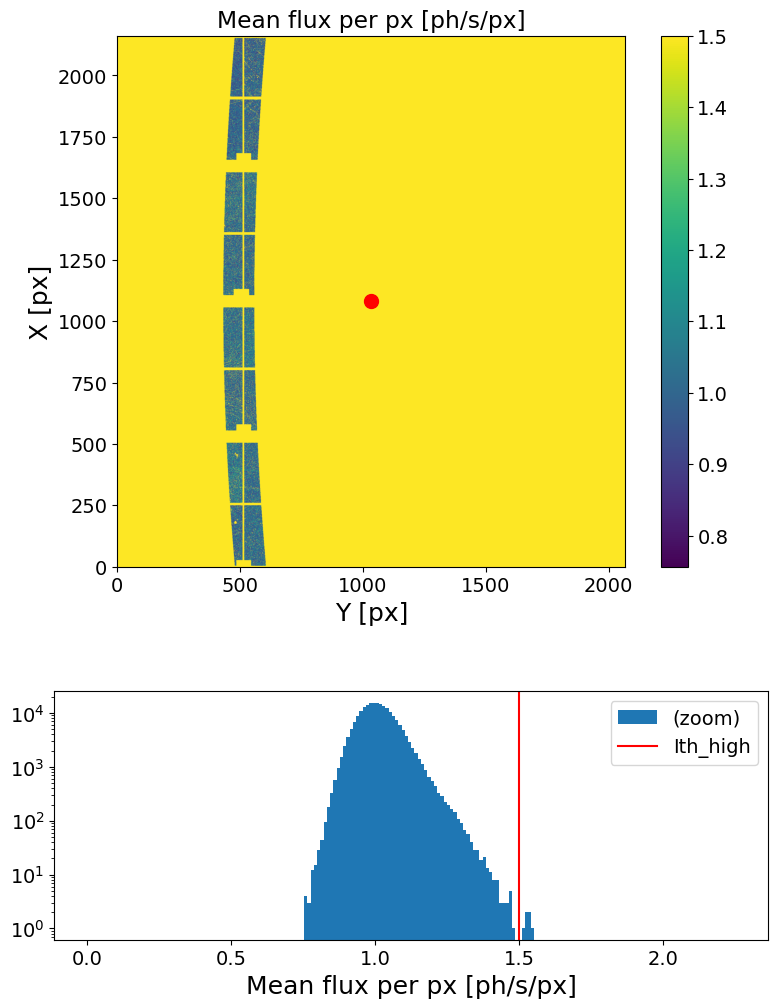

In [ ]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=1.5, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [ ]:
####################
Lbin = 1
Nstep = 100
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

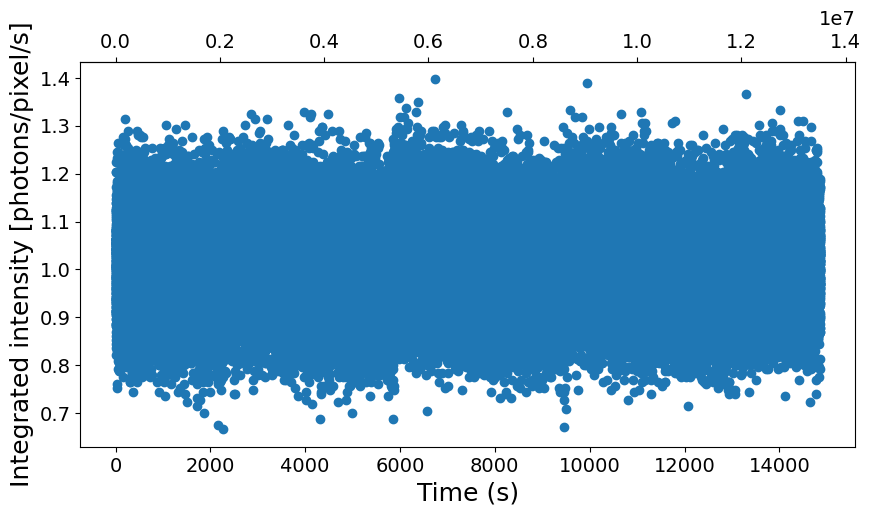

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.show()

### Linear correlation 4 tests

In [ ]:
###################
Nfi = int(0e7)
Nff = int(.5e7)
Lbin = 1000
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=True)

Loading frames ...
Done! (elapsed time = 6.28 s)
Binning frames (Lbin = 1000, using MKL library) ...
Done! (elapsed time = 1.46 s)
	 | 5000 frames X 210139 pixels
	 | memory usage (np.array @ float32) = 3.914 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 2.08 s)
	 | 5000 X 5000 squared matrix
	 | memory usage (np.array @ float32) = 0.093 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.53 s)



In [ ]:
############################
t1, t2 = 0, 100
vmin, vmax = 1.0, 1.03
############################
#XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=None)

In [ ]:
################
Nbunch = 3
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t, g2, t_mt, g2_mt = {}, {}, {}, {}
for n in range(Nbunch):
    
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=True)
    else:         t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t), cython=True)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch])    


Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)



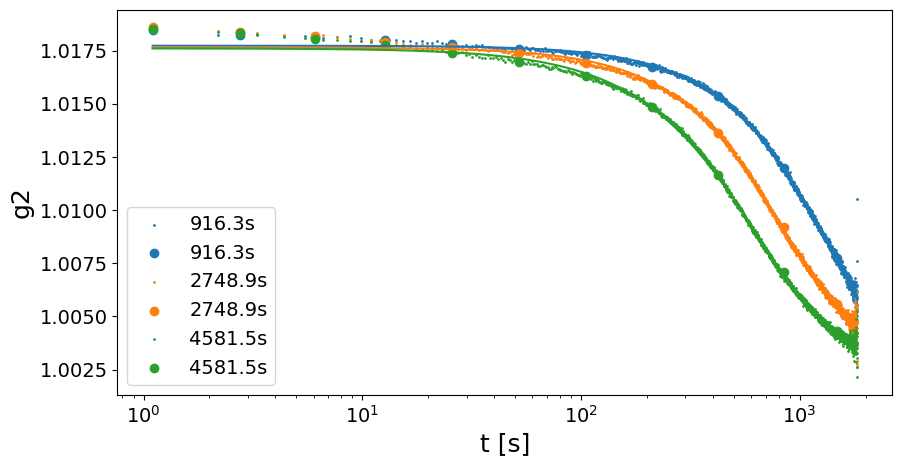

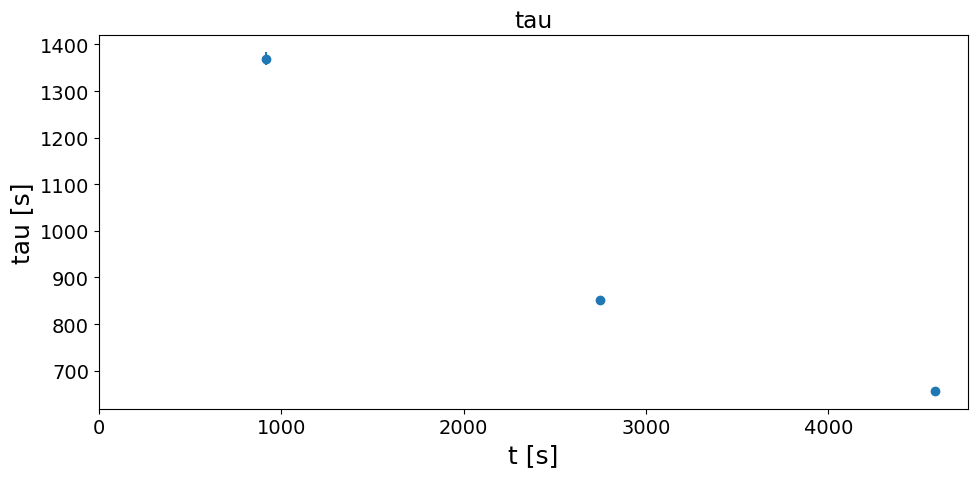

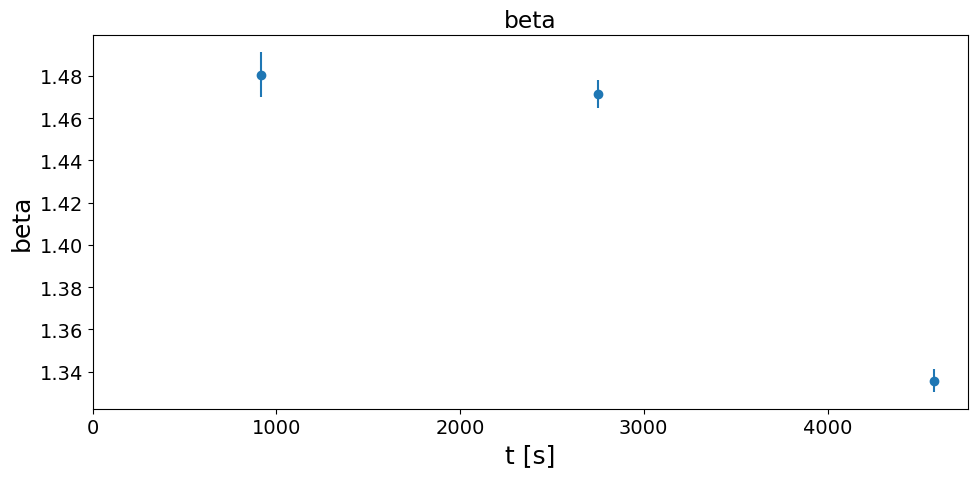

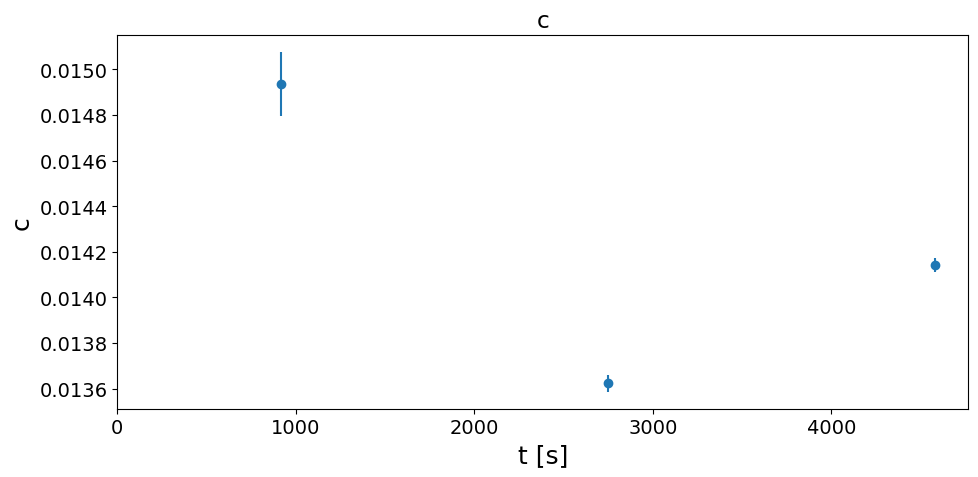

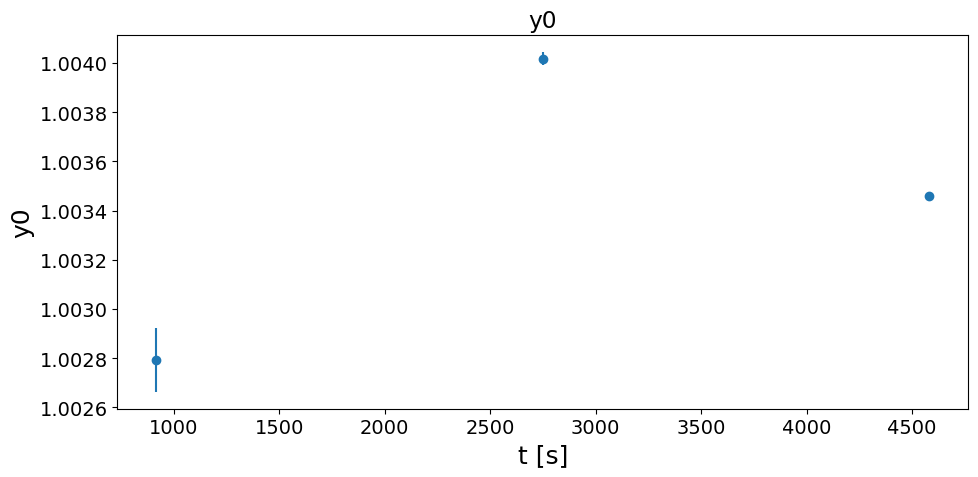

In [ ]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], c='C'+str(i), label=str(k)+'s')

    x = t[k] [(t1_fit<t[k])*(t[k]<t2_fit)]
    y = g2[k][(t1_fit<t[k])*(t[k]<t2_fit)]
    fit = model.fit(y, params, t=x)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
#plt.ylim(1, 1.03)
plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [ ]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 13506635  =>  t_ff = 14857.2985
#############################



In [ ]:
t_segments = [
    (0, 1.5e3),
    (1.5e3, 3e3),
    (3e3, 4.5e3),
    (4.5e3, 6e3),
    (6e3, 7.5e3),
    (7.5e3, 9e3),
    (9e3, 10.5e3),
    (10.5e3, 12e3),
    (12e3, 13.5e3),
]

Nf_segments =  [(int(t_segments[i][0]//itime), int(t_segments[i][1]//itime)) for i in range(len(t_segments))]

In [ ]:
###################
Lbin = 100
bin2dense = False
mask = None
###################

t_g2, g2= {}, {}
for i in range(len(Nf_segments)):
    Nfi = Nf_segments[i][0]
    Nff = Nf_segments[i][1]
    G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

    t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
    t_g2[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t), cython=True)
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2)

Loading frames ...
Done! (elapsed time = 1.66 s)
Binning frames (Lbin = 100, using MKL library) ...
Done! (elapsed time = 2.34 s)
	 | 13636 frames X 210139 pixels
	 | sparsity = 1.04e-01
	 | memory usage (sparse.csr_array @ float32) = 2.217 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 8.5 s)
	 | 13636 X 13636 squared matrix
	 | memory usage (np.array @ float32) = 0.693 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.07 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.07 s)

Loading frames ...
Done! (elapsed time = 0.71 s)
Binning frames (Lbin = 100, using MKL library) ...
Done! (elapsed time = 1.02 s)
	 | 13636 frames X 210139 pixels
	 | sparsity = 1.04e-01
	 | memory usage (sparse.csr_array @ float32) = 2.223 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 8.47 s)
	 | 13636 X 13636 squared matrix
	 | memory usage (np.array @ float32) = 0.693 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.09 s)



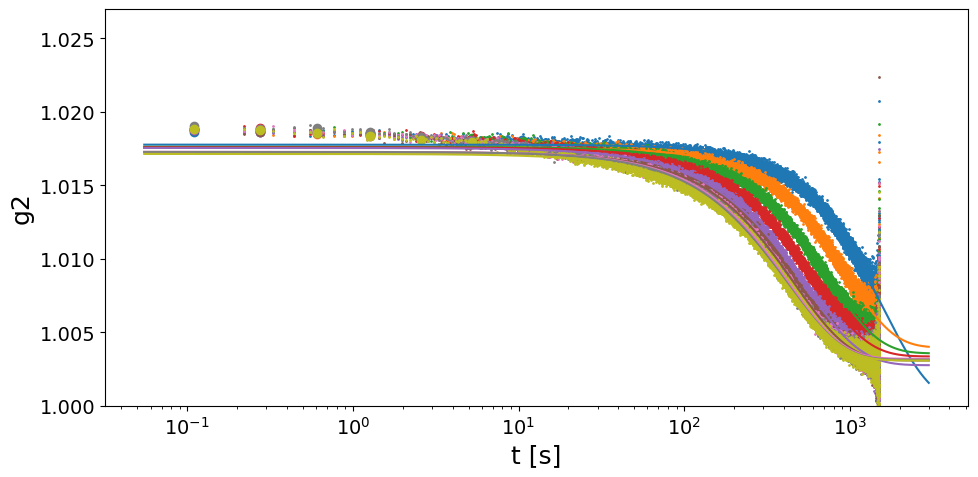

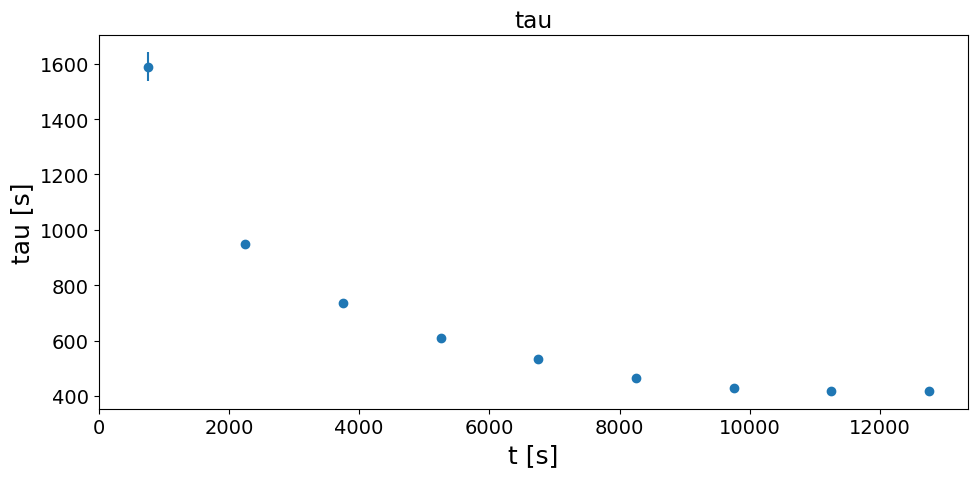

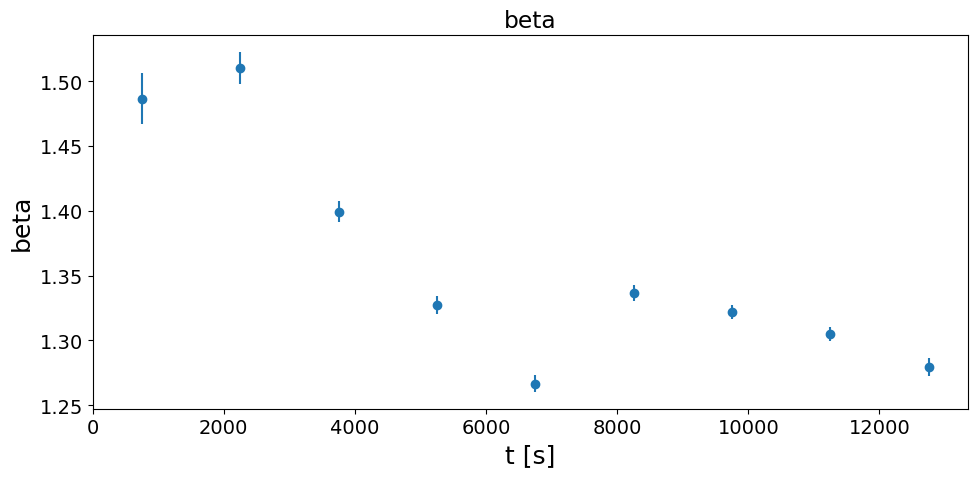

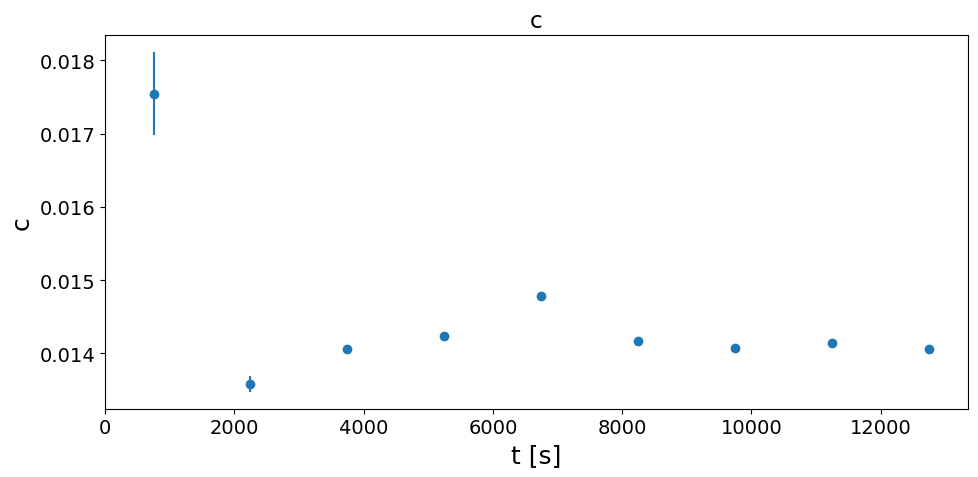

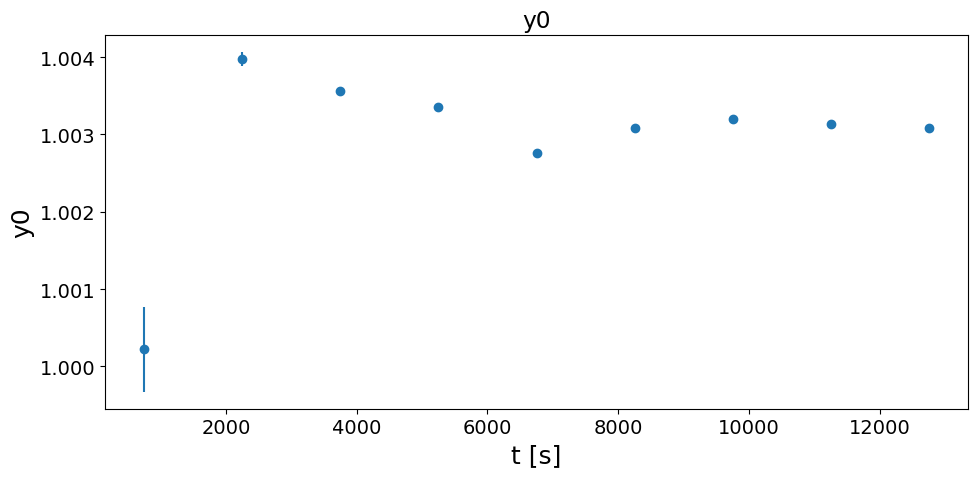

In [ ]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k])
    plt.scatter(t_mt, g2_mt, c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k])/2, np.max(t_g2[k])*2, 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y,)

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.027)
#plt.legend()
plt.tight_layout(); plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

## XPCS scan: delcoup=10, T=24h (Ta2O5_2.5um, 3, 9)

In [7]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset = 1
Nscan = 6
load_mask = e4m_mask*e4m_htmask*Qmask
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

##########################################################
Nfi, Nff = None, scan['fast_timer_period'].size-5001
##########################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  5.045340361111112 h
theta = 10.384625
Qc = 1.99
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/3302 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/3302 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/3302 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/3302 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/3302 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/3302 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/3302 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00053.h5 (54/3302 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00054.h5 (55/3302 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/3302 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00055.h5 (56/3302 loops)
	 -> loading file eiger4m_v2_sp

### Flux check

################################################################################
Maximum count in the hull run -> 5.0
# of pixels above Ith_high treshold ->  4260880 pixels (of 4471016 => 95.3 %)
################################################################################



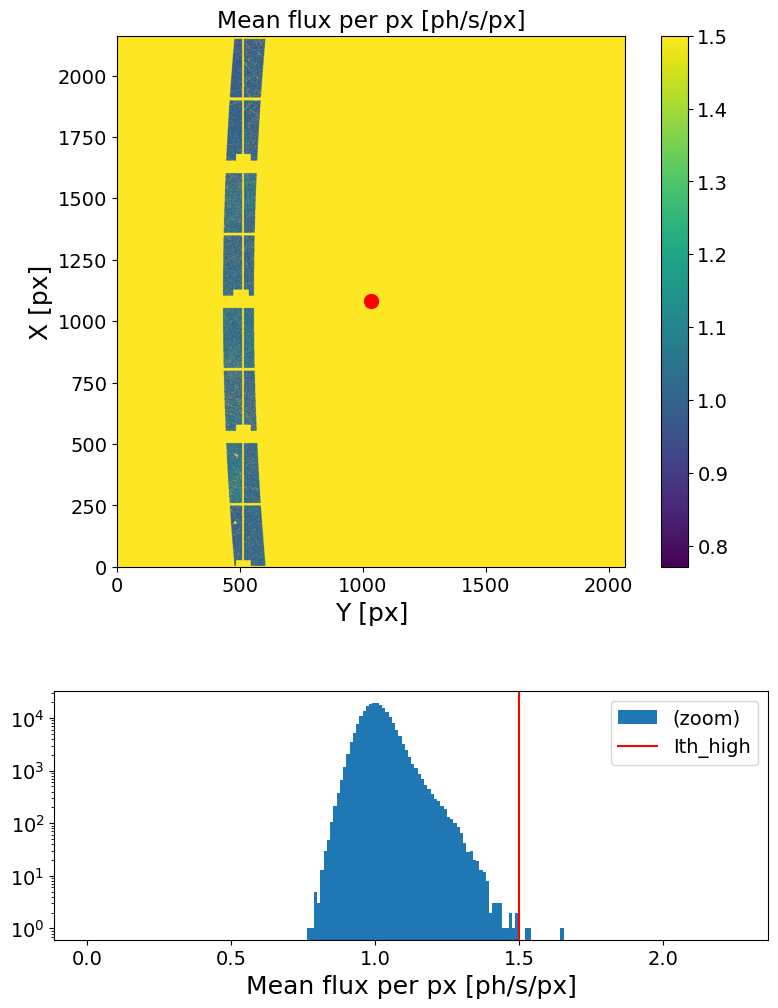

In [25]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=1.5, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [32]:
####################
Lbin = 100
Nstep = 10000
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

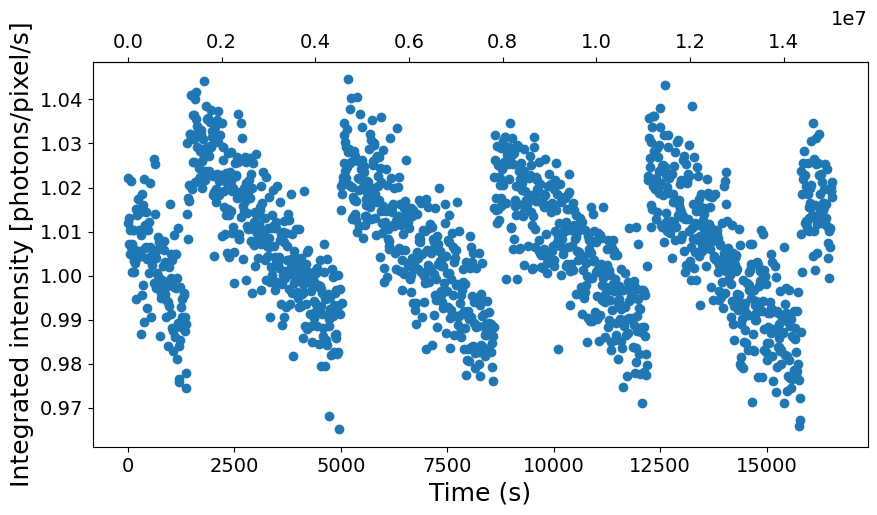

In [33]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.show()

### Linear correlation 4 tests

In [ ]:
###################
Nfi = None
Nff = None
Lbin = 1000
bin2dense = True
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

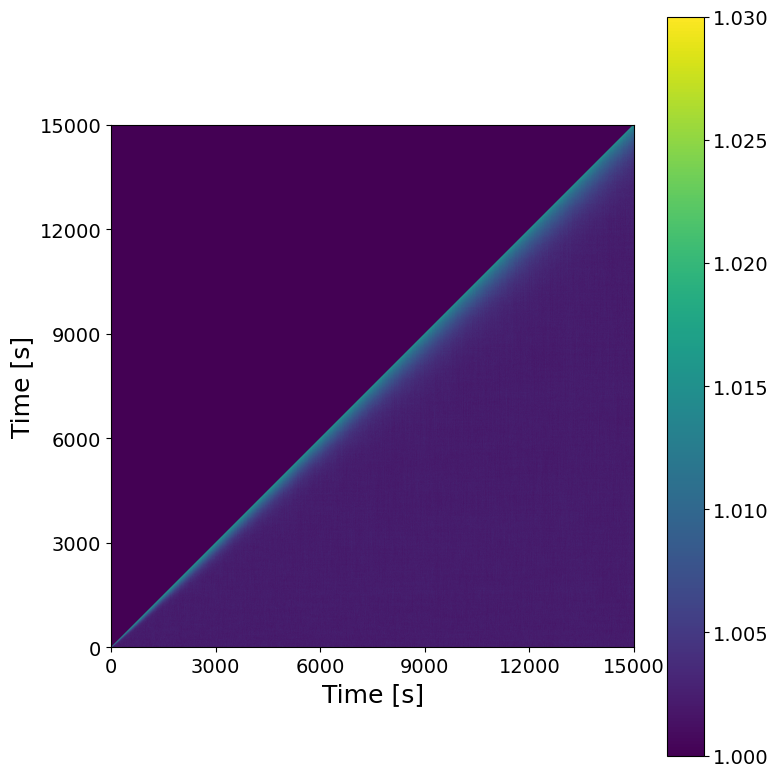

In [ ]:
############################
t1, t2 = 0, 15000
vmin, vmax = 1.0, 1.03
############################
#XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=None)

In [ ]:
################
Nbunch = 20
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t, g2, t_mt, g2_mt = {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=True)
    else:         t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t), cython=True)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch])    


Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)



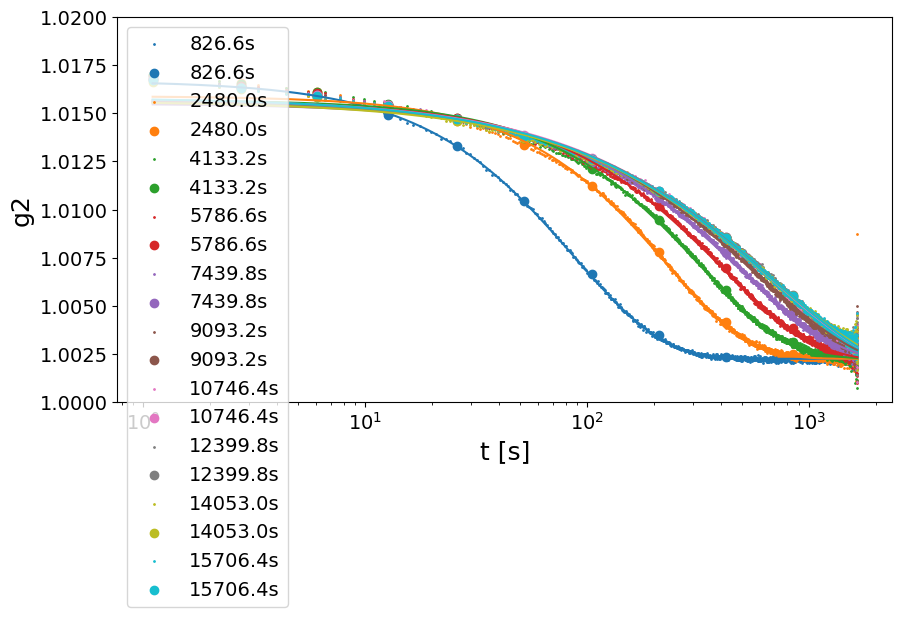

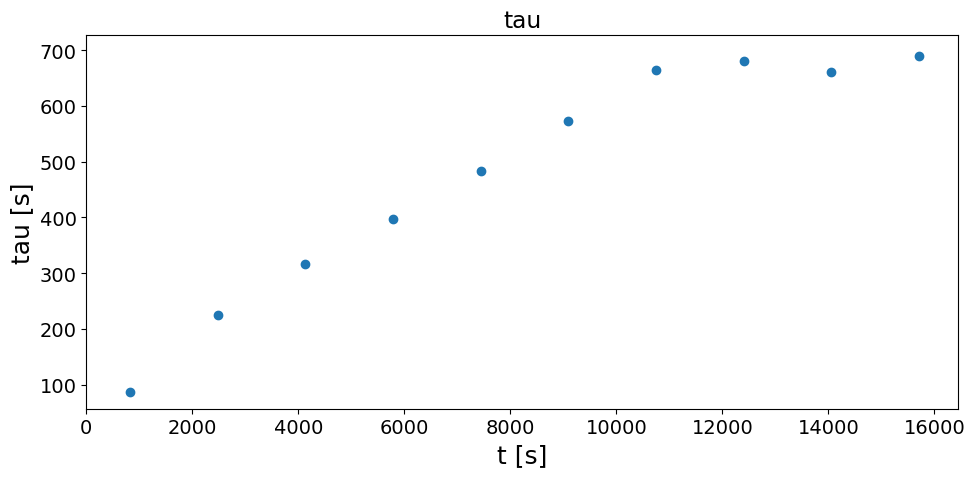

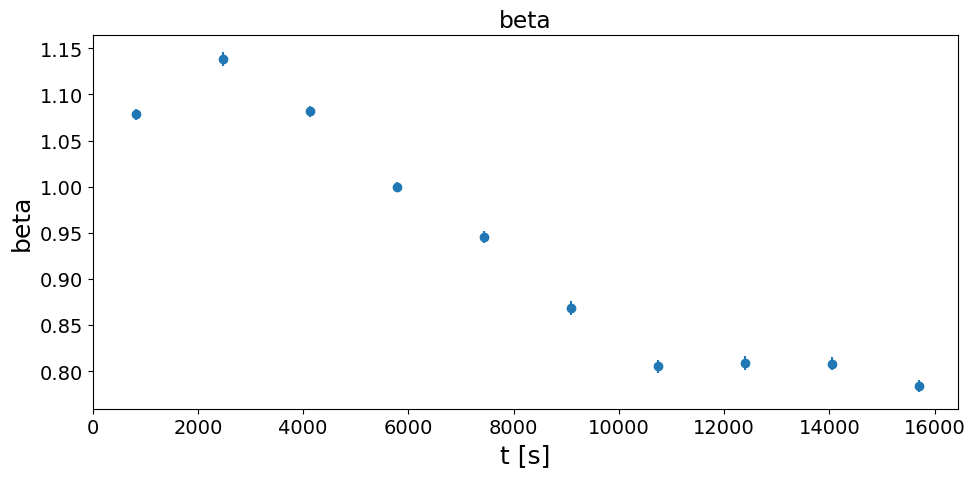

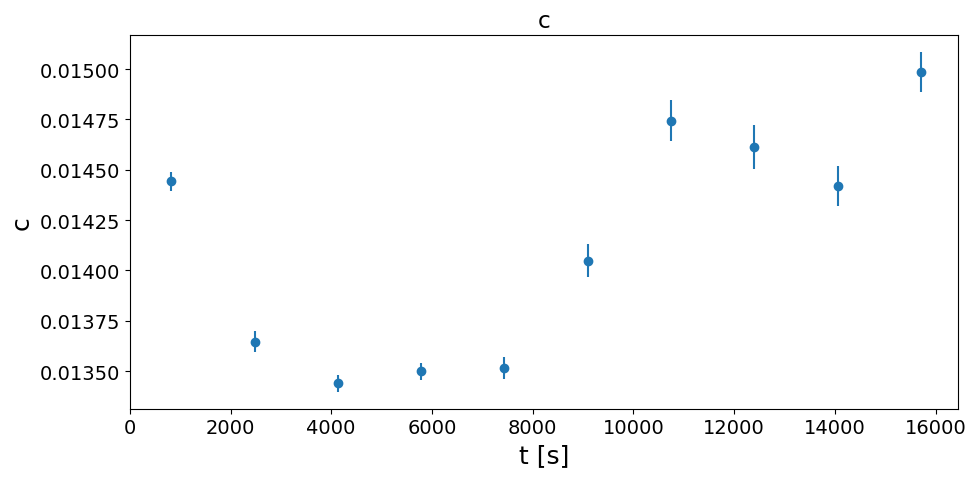

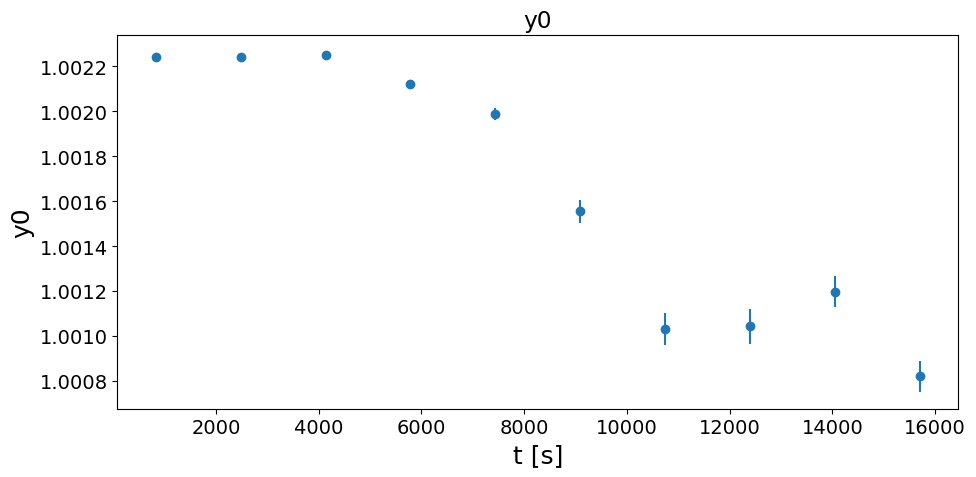

Exception ignored in: <function ResourceTracker.__del__ at 0x75d85482bc40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x70d6b794fc40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

In [ ]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], c='C'+str(i), label=str(k)+'s')

    x = t[k] [(t1_fit<t[k])*(t[k]<t2_fit)]
    y = g2[k][(t1_fit<t[k])*(t[k]<t2_fit)]
    fit = model.fit(y, params, t=x)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.02)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [8]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 16507022  =>  t_ff = 18157.7242
#############################



In [9]:
t_segments = [
    (0, 1.5e3),
    (1.5e3, 3e3),
    (3e3, 4.5e3),
    (4.5e3, 6e3),
    (6e3, 7.5e3),
    (7.5e3, 9e3),
    (9e3, 10.5e3),
    (10.5e3, 12e3),
    (12e3, 13.5e3),
    (13.5e3, 15e3),
]

Nf_segments =  [(int(t_segments[i][0]//itime), int(t_segments[i][1]//itime)) for i in range(len(t_segments))]

In [10]:
###################
Lbin = 100
bin2dense = False
mask = None
###################

t_g2, g2= {}, {}
for i in range(len(Nf_segments)):
    Nfi = Nf_segments[i][0]
    Nff = Nf_segments[i][1]
    G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

    t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
    t_g2[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t), cython=True)
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2)

Loading frames ...
Done! (elapsed time = 2.73 s)
Binning frames (Lbin = 100, using MKL library) ...
Done! (elapsed time = 3.84 s)
	 | 13636 frames X 210139 pixels
	 | sparsity = 1.03e-01
	 | memory usage (sparse.csr_array @ float32) = 3.313 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 12.51 s)
	 | 13636 X 13636 squared matrix
	 | memory usage (np.array @ float32) = 0.693 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.14 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.06 s)

Loading frames ...
Done! (elapsed time = 2.84 s)
Binning frames (Lbin = 100, using MKL library) ...
Done! (elapsed time = 3.77 s)
	 | 13636 frames X 210139 pixels
	 | sparsity = 1.05e-01
	 | memory usage (sparse.csr_array @ float32) = 3.374 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 10.78 s)
	 | 13636 X 13636 squared matrix
	 | memory usage (np.array @ float32) = 0.693 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.14 s

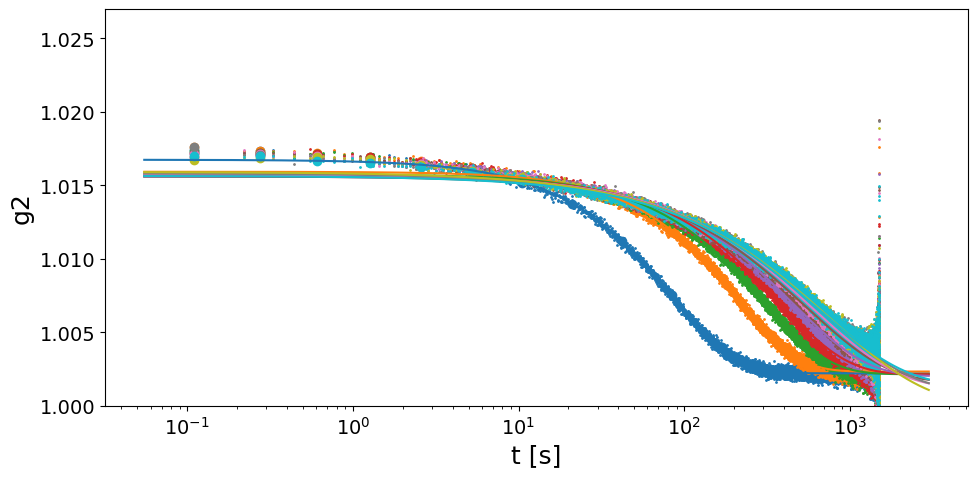

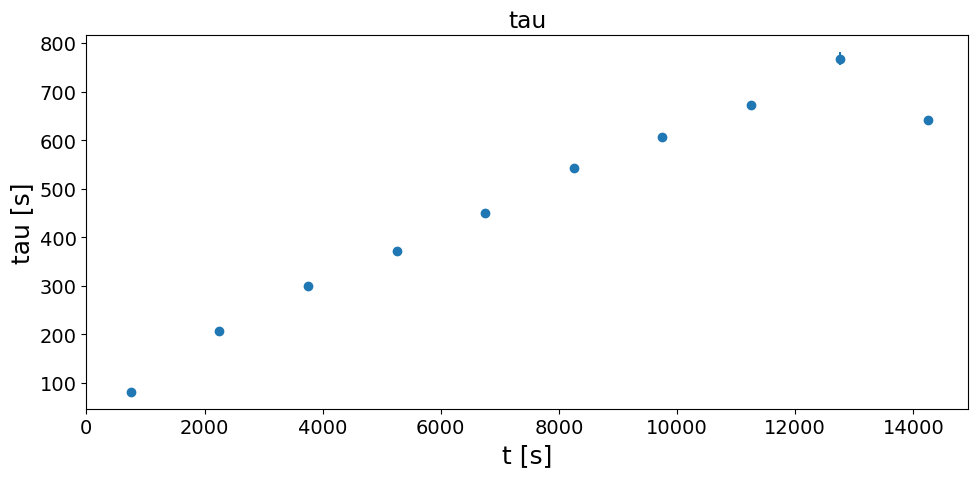

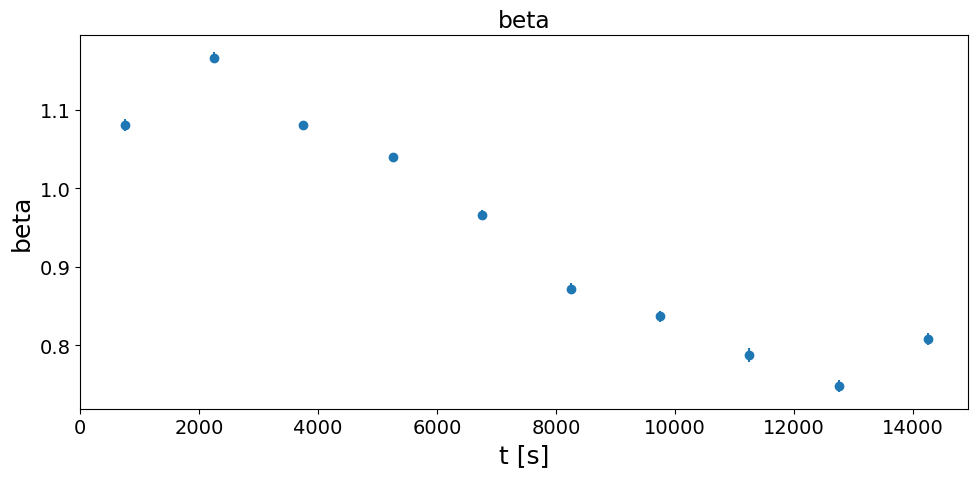

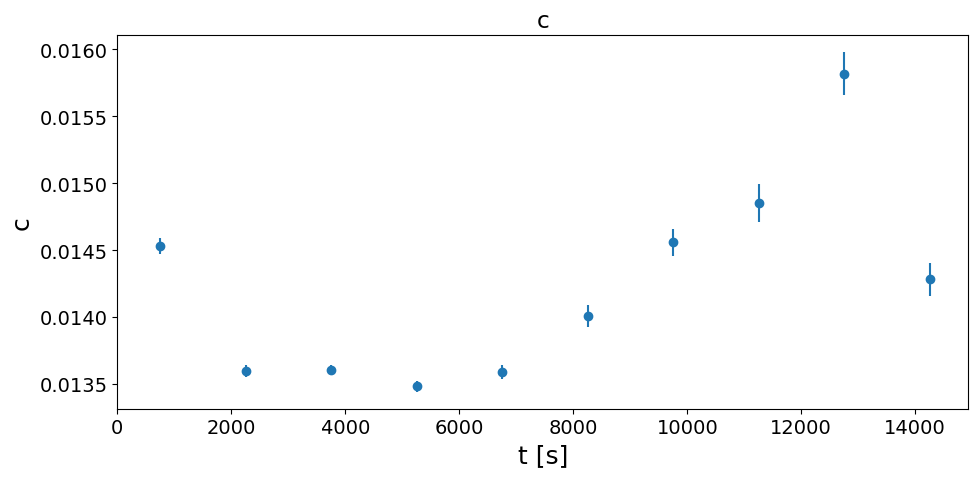

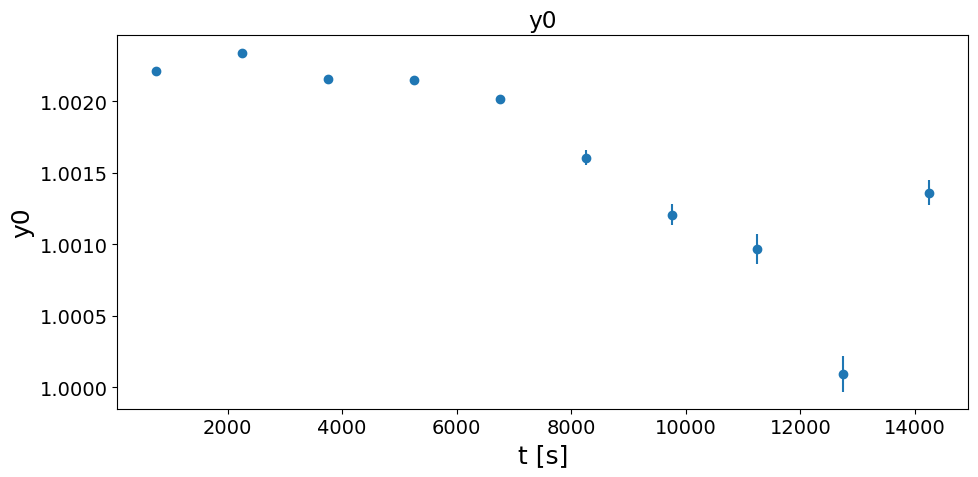

Exception ignored in: <function ResourceTracker.__del__ at 0x7cf4e4197c40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x706c01d97c40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

In [13]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k])
    plt.scatter(t_mt, g2_mt, c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k])/2, np.max(t_g2[k])*2, 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y,)

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.027)
#plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()